In [27]:
#Importing libraries
import tensorflow as tf
import keras 
from keras.models import model_from_json
from keras import backend
import numpy as np

import cv2

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as matp

import scipy.ndimage
from scipy import misc

#Randomly choosing pictures
import os
import random

import math
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Hyper parameters used in the original paper:¶

In [28]:
#Block size
B = 32

#Sensing rate R = M/N
#Sensing matrix is MxN
R = 0.25

#Number of reconstruction layers
#K =2 two hidden layers for reconstruction

#Redundancy factor
T = 8

# 1. Data

### 1.1 Reading the images from the file

In [3]:
#unzipping the file
import zipfile
zip_ref = zipfile.ZipFile('Data.zip', 'r') 
zip_ref.extractall('input_data') 
zip_ref.close()

In [29]:
#Reads all the images from the file and save them in a list as Type=unit8
#3-channels of the images share the same info. So one channel is only used
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        
        imagePath = os.path.join(folder,filename)
        
        if imagePath == folder + '.DS_Store':
            continue
        else:
            img = cv2.imread(imagePath,cv2.IMREAD_UNCHANGED)
            if img is not None:
                images.append(img[:,:,0])
                
    return images

In [30]:
images = load_images_from_folder('input_data/Data')

In [31]:
#test
print(type(images))
print(len(images))
print(images[0].shape)
print(images[0].dtype)
np.max(images[0])

<class 'list'>
100
(768, 1024)
uint8


254

In [32]:
#image shape
img_shape = images[0].shape

### 1.2 Compression and Decompression

In [33]:
#This function gets all the images and split them into blocks of BxB and save each block into a row of an array
def compression(image,B):#B is 16
    R = len(image)
    C = len(image[0])
    res = []
    
    for r in range(0,R,B):
        for c in range(0,C,B):
            #segment BxB blocks and faltten them into a vector with len=B^2
            tmp = image[r:B+r,c:c+B].flatten()
            res.append(tmp)
            
    return np.asarray(res)    

#This function gets an array with shape = (len(image)xlen(image[0])/B^2,B^2)
#Returns and image with shape len(image)xlen(image[0]) 
def decompression(arr,B,img_shape):
    numBlocks_R = int(img_shape[0]/B)
    numBlocks_C = int(img_shape[1]/B)
    
    #makes an empty array
    newImage=np.empty((img_shape[0],img_shape[1]))
    
    for r in range(numBlocks_R):
        for c in range(numBlocks_C):
            
            if arr.size != 0:
                tmp = arr[0].reshape((B,B))
                arr = np.delete(arr,0,0)
                newImage[r*B:(r+1)*B , c*B:(c+1)*B] = tmp
                
    return newImage

### 1.3 Function: Compress all the images and save them into a numpy array

In [34]:
def building_Input(images,B):
    input_X = []
    
    for i in images:
        input_X.extend(compression(i,B))
    return np.asarray(input_X)

In [35]:
#Test
test = building_Input(images,B)

In [36]:
#Each image construct 3072 images = 768/16 * 1024/16
print(len(test))
print(type(test))
print(len(test[0]))#should be B*B

76800
<class 'numpy.ndarray'>
1024


### 1.4 Splitting Data 

In [37]:
#Split your data to test and train
X_train_Or, X_test_Or, y_train_Or, y_test_Or = train_test_split(images,images, test_size=0.30, random_state=42)

In [38]:
print("Number of images in Training set: ",len(X_train_Or))
print("Number of images in Test set: ",len(X_test_Or))

Number of images in Training set:  70
Number of images in Test set:  30


In [14]:
def save_images_to_folder(folder,img_name,images):
    path = folder+"/"+ img_name
    for i,im in enumerate(images):
        cv2.imwrite(path+str(i)+'.JPEG',im)  
    return 

In [15]:
#Saving images in to a file
save_images_to_folder('train','train_',X_train_Or)
save_images_to_folder('test','test_',X_test_Or)

### 1.5 Making data ready for training

In [39]:
#Train
X_train = building_Input(X_train_Or,B)
y_train = X_train

#Test
X_test = building_Input(X_test_Or,B)
y_test = X_test

In [40]:
print("Number of blocks in Training set: ",len(X_train))
print("Number of blocks in Test set: ",len(X_test))

Number of blocks in Training set:  53760
Number of blocks in Test set:  23040


In [41]:
#cheking the dimensions
#105 images in training
print(X_train.shape)
print(y_train.shape)
#45 images in test
print(X_test.shape)
print(y_test.shape)

(53760, 1024)
(53760, 1024)
(23040, 1024)
(23040, 1024)


In [42]:
X_train

array([[ 68,  68,  68, ...,  74,  74,  74],
       [ 68,  68,  68, ...,  74,  74,  74],
       [ 74,  74,  74, ...,  73,  73,  73],
       ...,
       [175, 175, 174, ...,  68,  68,  68],
       [173, 173, 173, ...,  68,  68,  68],
       [173, 173, 173, ...,  68,  68,  68]], dtype=uint8)

# 2. Building the Model

### 2.1 Adding Layers

In [43]:
def build_Model(B,R,T):
    ##Set random seeds
    np.random.seed(23)
    tf.set_random_seed(23)
    
    #Creates a model
    model = keras.models.Sequential()
    
    #Add layers
    #First hidden layer
    model.add(
         keras.layers.Dense(
                            units = int(B*B*R),
                            input_dim = B*B,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'relu'))

    #First Reconstruction Layer
    model.add(
         keras.layers.Dense(
                            units = B*B*T,
                            input_dim = B*B*R,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'relu'))

    #Second Reconstruction Layer
    model.add(
         keras.layers.Dense(
                            units = B*B*T,
                            input_dim = B*B*T,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros',
                            activation = 'relu'))

    #Output Layer
    #If you don't specify any activation, no activation is applied. "linear" activation: a(x) = x).
    model.add(
         keras.layers.Dense(
                            units = B*B,
                            input_dim = B*B*T,
                            kernel_initializer = 'glorot_uniform',
                            bias_initializer='zeros'))
    return model

In [44]:
model = build_Model(B,R,T)

In [45]:
#A custome metric function
#https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio

def PSNR(y_true, y_pred):
    
    max_I = 255.0 
    
    loge = 10.0 * backend.log((max_I ** 2) / (backend.mean(backend.square(y_pred - y_true)))) 
    log10 = loge/backend.log(10.0)#backend.log is not base 10
    
    return log10

### 2.2 Optimizer and Cost Function

In [46]:
#Choose optimizer and a cost function

RMSprop_optimizer = keras.optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=1e-7)

model.compile(optimizer = RMSprop_optimizer , loss = 'mean_squared_error', metrics=[PSNR])

In [47]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_6 (Dense)              (None, 8192)              2105344   
_________________________________________________________________
dense_7 (Dense)              (None, 8192)              67117056  
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              8389632   
Total params: 77,874,432
Trainable params: 77,874,432
Non-trainable params: 0
_________________________________________________________________
None


### 2.3 Callbacks

In [48]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.PSNR = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.PSNR.append(logs.get('PSNR'))

In [49]:
loss_history = LossHistory()

### 2.3 Training the model

In [50]:
#Training
history = model.fit(X_train, y_train,
                    batch_size=64, epochs =50,
                    verbose = 1,#can follow the optimization during training
                    validation_data=(X_test, y_test),
                    callbacks=[loss_history])# check if the model overfitting by having validation set

Train on 53760 samples, validate on 23040 samples
Epoch 1/50
53760/53760 [==============================] - 78s 1ms/step - loss: 301.1776 - PSNR: 26.9380 - val_loss: 75.9485 - val_PSNR: 29.7998
Epoch 2/50
53760/53760 [==============================] - 76s 1ms/step - loss: 68.2740 - PSNR: 30.0227 - val_loss: 65.1376 - val_PSNR: 30.3346
Epoch 3/50
53760/53760 [==============================] - 76s 1ms/step - loss: 54.6670 - PSNR: 31.0032 - val_loss: 48.8200 - val_PSNR: 31.7661
Epoch 4/50
53760/53760 [==============================] - 76s 1ms/step - loss: 47.1909 - PSNR: 31.6208 - val_loss: 47.2092 - val_PSNR: 31.8079
Epoch 5/50
53760/53760 [==============================] - 76s 1ms/step - loss: 42.3419 - PSNR: 32.0930 - val_loss: 34.7060 - val_PSNR: 33.5790
Epoch 6/50
53760/53760 [==============================] - 76s 1ms/step - loss: 38.7342 - PSNR: 32.4818 - val_loss: 36.7408 - val_PSNR: 33.0103
Epoch 7/50
53760/53760 [==============================] - 76s 1ms/step - loss: 36.1530 - PS

#### 2.3.1 Saving the Model and the History

In [51]:
#Saving the model 

model_json = model.to_json()
with open("model3_B32_1.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model3_B32_1.h5")
print("Saved model to disk")

Saved model to disk


In [52]:
#save the history of training
import pickle
pickle_out = open("history3_B32_1.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

#### 2.3.2 Uploading the Model and the History 

In [ ]:
#load json and create model

json_file = open('model3_B8.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
model.load_weights("model3_B8.h5")

In [ ]:
#if you load your model and weights you need to compile it again
model.compile(optimizer = adam_optimizer , loss = 'mean_squared_error', metrics=[PSNR])

# 3.Predicting

In [53]:
y_train_pred = model.predict(X_train,verbose = 1)
y_test_pred = model.predict(X_test,verbose = 1)

23040/23040 [==============================] - 5s 211us/step


In [54]:
y_train_pred

array([[ 64.85961 ,  72.30442 ,  72.75537 , ...,  76.869125,  70.92377 ,
         67.961075],
       [ 71.15897 ,  70.49197 ,  70.668304, ...,  75.9432  ,  75.27314 ,
         74.02198 ],
       [ 75.03944 ,  74.74569 ,  74.96935 , ...,  74.83086 ,  74.070114,
         72.73755 ],
       ...,
       [178.62198 , 177.33008 , 177.90002 , ...,  71.1454  ,  68.90284 ,
         67.7115  ],
       [175.49017 , 174.63185 , 176.28351 , ...,  71.30649 ,  70.642044,
         68.00785 ],
       [175.16893 , 173.68562 , 174.31958 , ...,  73.19019 ,  71.60027 ,
         62.742516]], dtype=float32)

In [55]:
y_test_pred

array([[ 68.944664,  75.02212 ,  66.18363 , ...,  79.80441 ,  73.98494 ,
         70.11463 ],
       [ 71.18616 ,  71.135506,  70.5142  , ...,  75.13823 ,  75.03035 ,
         73.99197 ],
       [ 74.81188 ,  74.376686,  74.60875 , ...,  74.80549 ,  74.06646 ,
         72.47552 ],
       ...,
       [177.98009 , 176.03246 , 175.89331 , ...,  67.955185,  66.45581 ,
         63.598774],
       [169.95155 , 168.43024 , 169.43654 , ...,  68.479095,  67.90043 ,
         64.45664 ],
       [173.9159  , 173.52602 , 174.06006 , ...,  71.01514 ,  69.91429 ,
         61.167088]], dtype=float32)

# 4. Evaluation

In [56]:
#Evaluate on the whole image
imgL = int(img_shape[0]*img_shape[1]/(B*B))

scores_Train = model.evaluate(X_train, y_train, verbose=1,batch_size=imgL)

print("Training PSNR:")
print("%s: %.2f%%" % (model.metrics_names[1], scores_Train[1]))

53760/53760 [==============================] - 4s 75us/step
Training PSNR:
PSNR: 36.53%


In [57]:
scores_Test = model.evaluate(X_test, y_test, verbose=1,batch_size=imgL)

print("Test PSNR:")
print("%s: %.2f%%" % (model.metrics_names[1], scores_Test[1]))

23040/23040 [==============================] - 2s 70us/step
Test PSNR:
PSNR: 35.47%


### 4.1 Plots

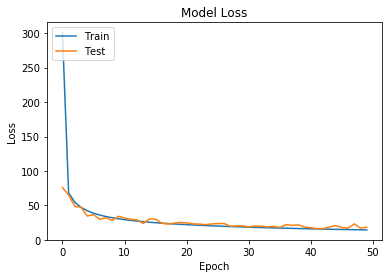

In [58]:
#plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

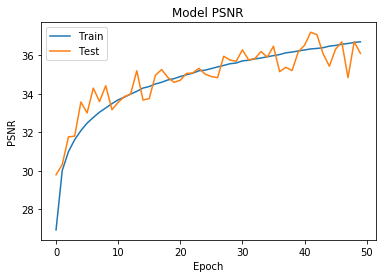

In [59]:
#plotting PSNR
plt.plot(history.history['PSNR'])
plt.plot(history.history['val_PSNR'])
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 5. Reconstrcut the predicted images

### 5.1 Function: reconstrcution

In [60]:
#number of rows for each image = (len(image)xlen(image[0])/B^2
#gets an array and reconstruct the images
def building_output(result,img_shape):
    
    imgL = int(img_shape[0]*img_shape[1]/(B*B))
    out_put = []
    
    for i in range(0,len(result),imgL):
        out_put.append(decompression(result[i:i+imgL],B,img_shape))
    
    return out_put

### 5.2 Reconstrcuting train and test

In [61]:
#reconstructing train predictions
dec_img_train = building_output(y_train_pred,img_shape)

#reconstructing test predictions
dec_img_test = building_output(y_test_pred,img_shape)

In [62]:
#test
print(len(dec_img_train))
print(len(dec_img_test))

70
30


### 5.3 Plotting images

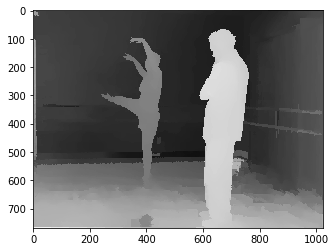

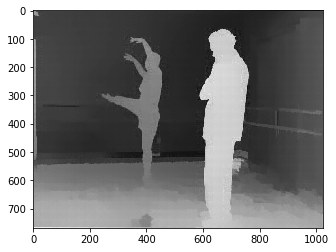

36.437536981194356


In [64]:
#train
img_in=X_train_Or[50]
img_out = dec_img_train[50]
imgplot = plt.imshow(img_in,cmap='gray')
plt.show()
imgplot = plt.imshow(img_out,cmap='gray')
plt.show()
print(PSNR_Final(img_in,img_out))#PSNR_Final is in section 5.4

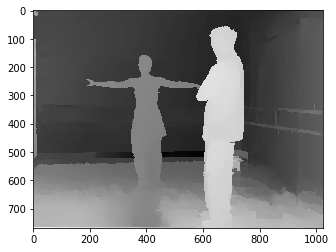

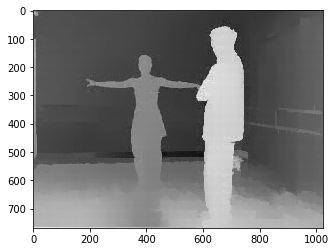

35.92039725142832


In [65]:
#test
img_in_t=X_test_Or[15]
img_out_t = dec_img_test[15]
imgplot = plt.imshow(img_in_t,cmap='gray')
plt.show()
imgplot = plt.imshow(img_out_t,cmap='gray')
plt.show()
print(PSNR_Final(img_in_t,img_out_t))

### 5.3 Saving images

In [66]:
def save_images_to_folder(folder,img_name,images):
    path = folder+"/"+ img_name
    for i,im in enumerate(images):
        cv2.imwrite(path+str(i)+'.png',im)  
    return 

In [67]:
#saving the precited images
save_images_to_folder('train_pred','train_p_B32_1_',dec_img_train)
save_images_to_folder('test_pred','test_p_B32_1_',dec_img_test)

### 5.4 Find the average PSNR 

In [63]:
#Calculate PSNR on the whole image
def PSNR_Final(y_true, y_pred):
    max_I = 255.0 #in this dataset #double check with get the max(img)
    tmp =  np.mean(np.square(y_pred - y_true))
    log_res = 10 * np.log10((max_I ** 2) /tmp)
    
    return log_res

In [68]:
#calcualte the average PSNR on a data set
def cal_PSNR_Dataset(output_images,input_images):
    res_psnr = []
    for i,o in enumerate(output_images):
        res_psnr.append(PSNR_Final(input_images[i],o))
    return res_psnr

In [69]:
res_psnr_train = cal_PSNR_Dataset(dec_img_train,X_train_Or)
print("average PSNR on training: ",np.mean(res_psnr_train))

average PSNR on training:  36.52640002137149


In [70]:
res_psnr_train

[36.19572163132842,
 36.62465862930115,
 36.64987761614262,
 36.58186554140859,
 36.2833251801985,
 37.1309443036983,
 35.87284398273247,
 36.347851778005776,
 36.49395604944371,
 36.34606669960924,
 36.30140852890728,
 36.835671187308414,
 36.21872566732888,
 36.876345180046634,
 36.48981307373251,
 36.63844566779863,
 35.81142638558906,
 36.397240981229025,
 36.216343326559695,
 35.788370925069316,
 36.692739078391604,
 36.66009314518745,
 36.67790778141381,
 36.22206921255874,
 36.50134884086083,
 35.84332953742302,
 36.34378146478443,
 36.30611665318655,
 36.644001798231656,
 36.84109354101109,
 35.92736441842492,
 37.06459505241513,
 36.93683630131224,
 37.020656348236926,
 36.82887854583982,
 36.67962083983931,
 36.56355992178006,
 35.99907961890837,
 36.59163365198633,
 36.88227232475387,
 36.55180166503232,
 36.774716933150195,
 36.405040631759505,
 36.86031034208116,
 36.718182953373805,
 36.12307951843054,
 36.45554304094596,
 36.47175578899136,
 36.788694862482046,
 36.46744

In [71]:
res_psnr_test = cal_PSNR_Dataset(dec_img_test,X_test_Or)
print("average PSNR on the test set: ",np.mean(res_psnr_test))

average PSNR on the test set:  35.47302197187836


In [72]:
res_psnr_test

[35.533302024993695,
 35.58271762880264,
 36.28495773221275,
 35.90739603793116,
 36.09431727274546,
 35.66590493860523,
 35.74888043678639,
 35.81708496097286,
 35.28891616144303,
 35.962011467809845,
 35.956998287537125,
 35.11233544862795,
 34.80036680693023,
 35.570471091022654,
 35.94704245274448,
 35.92039725142832,
 34.89625145547083,
 34.79954890874243,
 34.95667341218814,
 35.51007436473419,
 35.01097929431465,
 35.289274452320484,
 35.677836417575215,
 34.63237374492596,
 35.60661710209169,
 35.89785006211586,
 35.43762106083263,
 34.52247687955847,
 35.19387111846368,
 35.56611088242289]